# 創薬ちゃん統計

この記事は創薬アドベントカレンダー2日目の記事です。  
[創薬 Advent Calendar 2017 - Adventar](https://adventar.org/calendars/2412)

## Overview
- [創薬ちゃん(@souyakuchan)](https://twitter.com/souyakuchan) の化合物描画Bot機能でこれまでに詠唱された化合物を集計してみた
- API操作には [Tweepy](http://www.tweepy.org/) と [ddquest/chem_bot](https://github.com/ddquest/chem_bot) を使用
- 取得日は 12/1（金）
- 特に理由は無いですがPythonのバージョンは 3.5.3 です

## 下準備
早速やっていきましょう。まずはデータ取得のための下準備としてPythonによるTwitter API認証とツイート取得方法を確認します。

### API 認証
tweepy を使用して予め登録したアクセストークンでOAuth認証します。

In [1]:
import tweepy

consumer_key = 'XXXXXXXXXXXXXXXXXXXXXX'
consumer_secret ='XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
access_token = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
access_token_secret = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

### ツイートの本文を取得してみる
創薬ちゃんの最新ツイートを1件取得して`status.text`の中身を見てみます。

集計時点での最新ツイートです。
<blockquote class="twitter-tweet" data-conversation="none" data-cards="hidden" data-lang="ja"><p lang="cy" dir="ltr">&quot;CC1CC2(C)C(=CC1=O)CCC1C3CCC(O)(C(=O)CO)C3(C)CC(O)C12F&quot; #souyakuchan_magic pic.twitter.com/Ki3gTIYIcu</p>&mdash; 創薬ちゃん (@souyakuchan) 2017年12月1日</blockquote>

In [2]:
status = next(tweepy.Cursor(api.user_timeline).items())
print(status.text)

@__YamYuki__ @souyakuchan "CC1CC2(C)C(=CC1=O)CCC1C3CCC(O)(C(=O)CO)C3(C)CC(O)C12F" #souyakuchan_magic https://t.co/Ki3gTIYIcu


### メンション付きツイートを取得してみる
次は、創薬ちゃんにメンションされたツイートを取得してみます。  
tweepyの`api.mentions_timeline()`が便利です。

ドキュメントを見る際にlatestかどうか確認したほうが良いです。  
http://docs.tweepy.org/　にアクセスすると `3.5.0` に誘導されるのですが、そこにはこのメソッドがありません。  
latestはこちらです。 http://docs.tweepy.org/en/latest

In [3]:
mention = next(tweepy.Cursor(api.mentions_timeline).items())

In [4]:
mention.text

"Today's post: https://t.co/Bgvlul5q8S @Lizreel_spindle @souyakuchan @OrenoSource @edamame0811 @bachemis… https://t.co/iXGugBWAtI"

### 投稿者を取得してみる
誰がツイートしたかわからないので、投稿者情報も取得してみます。  

In [5]:
print('screen name: @{}'.format(mention.user.screen_name))
print('user name:', mention.user.name)

screen name: @suimye
user name: 無印良品


## ツイート分析
基本的なツイート取得方法がわかったのでツイート内容を分析していきます。  
どんどんPythonで処理していきます。

In [6]:
smiles = []
iupacs = []

for mention in tweepy.Cursor(api.mentions_timeline).items():
    if 'http' in mention.text:
        continue
    split_texts = mention.text.split(':')
    prefix = split_texts[0]

    if len(split_texts) > 1:    
        tweet_text = split_texts[1].lstrip(' ').replace('\n', '')
    
    if 'smiles' in prefix.lower():
        # トリガーとして smiles: を取り除いたあとの後ろのテキストから改行を取り除いて連結
        smiles.append((mention.user.screen_name, tweet_text))
    elif 'iupac' in prefix.lower():
        # トリガーとして iupac: を取り除いたあとの後ろのテキストから改行を取り除いて連結
        iupacs.append((mention.user.screen_name, tweet_text))

### クレンジング
期待通り行けば詠唱呪文（ `iupac: ~~~~` or `smiles: ~~~~~` ）のみを取ってこられるはずですが、除外できていないのも混じるので、思い切って[RDKit](http://www.rdkit.org/)でパースできるものだけ残します。  

期待していないけど入っちゃうものの例：` ('souyakuchan', 'SMILES式""@souyakuchan iupac')`  

IUPAC名についてはちょっと面倒なので化合物詠唱bot同様に、ASCII変換できない文字が含まれるものは除外することにしました。

In [7]:
from rdkit import Chem

smiles_clean = [(user, smi) for user, smi in smiles if Chem.MolFromSmiles(smi)]

In [8]:
print('クレンジング前のSMILES数:', len(smiles))
print('RDKitでパース可能なSMILES数:', len(smiles_clean))
print('RDKitでパース可能なSMILES数（重複なし）:', len(set(smiles_clean)))

クレンジング前のSMILES数: 263
RDKitでパース可能なSMILES数: 222
RDKitでパース可能なSMILES数（重複なし）: 202


In [9]:
def check_ascii(sｔrings):
    """Except multibyte characters in strings."""
    try:
        strings.encode('ascii')
        return True
    except UnicodeEncodeError:
        return False

In [10]:
iupacs_clean = [(user, ipc) for user, ipc in iupacs if check_ascii(ipc)]

In [11]:
print('クレンジング前のIUPAC名数:', len(iupacs))
print('ASCII変換できるIUPAC名数:', len(iupacs_clean))
print('ASCII変換できるIUPAC名数（重複なし）:', len(set(iupacs_clean)))

クレンジング前のIUPAC名数: 186
ASCII変換できるIUPAC名数: 175
ASCII変換できるIUPAC名数（重複なし）: 155


### SMILES投稿者ランキング
誰が一番たくさん創薬ちゃんにSMILESを投げたか調べます（重複を含む）。  
こういうときは `collections`が便利です。  
`sorted`を使って上手く降順に投稿数を並び替えます。

In [12]:
import collections
smi_count_result = collections.Counter([user for user, smi in smiles_clean])
smi_count_result_sorted = sorted(smi_count_result.items(), key=lambda x:x[1], reverse=True)

In [13]:
print('SMILESを投稿したことのある人の数:', len(smi_count_result_sorted))

SMILESを投稿したことのある人の数: 38


#### SMILES投稿数をユーザー別にプロットする
折角なのでプロットしてみましたが、完全に出来レースでしたね。  
あと、思ったよりも投稿している人の数が多いです。１０人ぐらいで楽しんでいるのかと少しさびしくも思っていましたが、そんなことないですね。

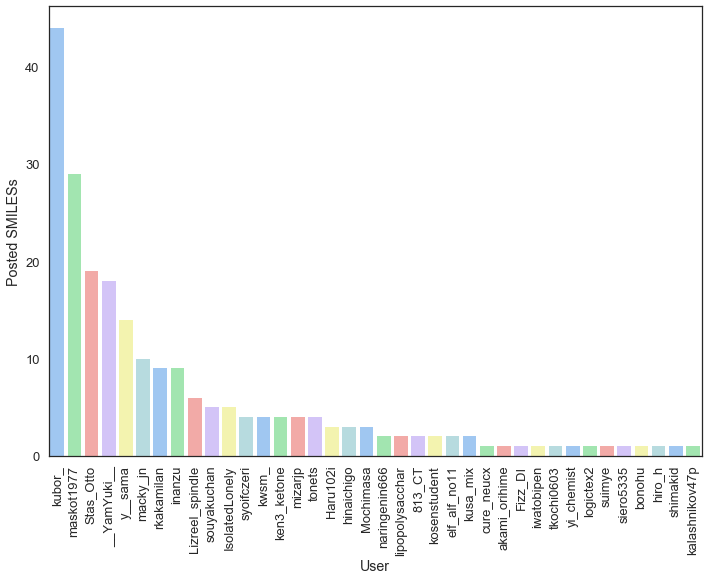

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
sns.set(style="white", context="talk")

x = [x for x, y in smi_count_result_sorted]
y = [y for x, y in smi_count_result_sorted]

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)  # 思い切ってA4サイズにしよう!！

g = sns.barplot(x, y, palette='pastel', ax=ax)
plt.ylabel('Posted SMILESs')
plt.xlabel('User')
loc, labels = plt.xticks()
text_config = g.set_xticklabels(labels, rotation=90)

### IUPAC名投稿数ランキング
同じ方法でやってみます。

In [15]:
ipc_count_result = collections.Counter([user for user, iupac in iupacs_clean])
ipc_count_result_sorted = sorted(ipc_count_result.items(), key=lambda x:x[1], reverse=True)

In [16]:
print('IUPAC名を投稿したことのある人の数:', len(ipc_count_result_sorted))

IUPAC名を投稿したことのある人の数: 38


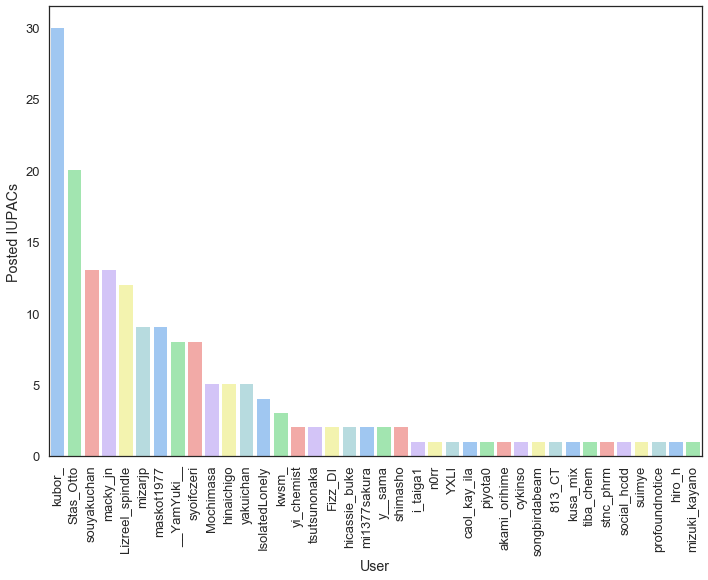

In [17]:
x = [x for x, y in ipc_count_result_sorted]
y = [y for x, y in ipc_count_result_sorted]

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)  # 思い切ってA4サイズにしよう!！

g = sns.barplot(x, y, palette='pastel', ax=ax)
plt.ylabel('Posted IUPACs')
plt.xlabel('User')
loc, labels = plt.xticks()
text_config = g.set_xticklabels(labels, rotation=90)

### 全投稿者リストを作ってみる
創薬ちゃんと遊んでくれた愉快なユーザー一覧表が欲しいですね。作りましょう。  

In [18]:
all_users = set(list(ipc_count_result.keys()) + list(smi_count_result.keys()))
print('愉快なユーザー様数:', len(all_users))
print('愉快なユーザー様:', ', '.join(all_users))

愉快なユーザー様数: 55
愉快なユーザー様: i_taiga1, n0rr, hicassie_buke, akami_orihime, tsutsunonaka, Stas_Otto, inanzu, lipopolysacchar, Fizz_DI, iwatobipen, kusa_mix, tkochi0603, caol_kay_ila, IsolatedLonely, yi_chemist, shimasho, yakuichan, kosenstudent, logictex2, elf_alf_no11, mi1377sakura, mizuki_kayano, YXLI, Haru102i, siero5335, bonohu, tonets, __YamYuki__, maskot1977, cure_neucx, social_hcdd, rkakamilan, souyakuchan, piyota0, naringenin666, songbirdabeam, kwsm_, macky_jn, cykinso, 813_CT, Lizreel_spindle, tiba_chem, kubor_, ken3_ketone, y__sama, Mochimasa, hinaichigo, stnc_phrm, suimye, profoundnotice, syoifczeri, hiro_h, shimakid, mizarjp, kalashnikov47p


どちらかのみを使っているユーザーもいるんですね。  

### 変換できなかったSMILESを抽出してみる
分析をすすめます。  
変換できなかったSMILESについては、 `すまない。このSMILESは上手く変換できなかったようだ。` という創薬ちゃんのお決まりの台詞があるのでこれをフラグに集計します。

In [19]:
unrecognized_smiles = []

for status in tweepy.Cursor(api.user_timeline).items():
    if status.text.find('すまない。このSMILESは上手く変換できなかったようだ。') != -1:
        unrecognized_smiles.append(status.text.split('。')[2].replace('"', ''))

In [20]:
print('変換できなかったSMILES数:', len(unrecognized_smiles))

変換できなかったSMILES数: 26


全部で26件の変換できなかったSMILESたちを抽出できました。

In [21]:
print('重複していたSMILES:', int(len(unrecognized_smiles)) - int(len(set(unrecognized_smiles))))

重複していたSMILES: 1


重複しているSMILESが1件あるので、　`collections.Counter()`を使って抽出してみます。

In [22]:
counted = collections.Counter(unrecognized_smiles)
print('duplicated', [(smiles, count) for smiles, count in counted.items() if count > 1])

duplicated [('CC(=O)[O-][Na+]', 2)]


`CC(=O)[O-][Na+]` が2回ありました。

#### ほんとに変換できないのか
念のためほんとに変換できないかRDKitで読み込んで確かめてみます。  
上でも書きましたが、RDKitの`Chem.MolFromSmiles()`は変換できないSMILESが引数に与えられると`None`を返しますので、これを使って判定します。  
実際に創薬ちゃんの化合物詠唱機能でもこのメソッドを使用しています。

In [23]:
from rdkit import Chem

mol = [Chem.MolFromSmiles(smiles) for smiles in unrecognized_smiles]

mol

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

すべて`None`でした。  
ただしこれらのSMILESすべてがSMILESとして成り立たないというわけではなく、あくまでRDKitでの解釈ができないSMILESであるということを意味します。

#### 変換できるSMILESでも試しておく
一応変換可能なSMILESも試してみます。  
ついでにJupyter notebook 上で簡単に化合物の構造式を描画する機能が用意されているので、これを使って構造式も描いて見ます。

mol: <rdkit.Chem.rdchem.Mol object at 0x10c687080>


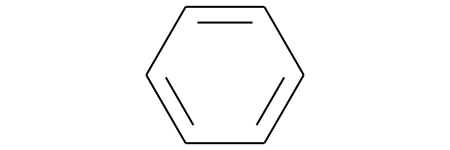

In [24]:
from rdkit.Chem.Draw import IPythonConsole

smiles = 'c1ccccc1'
mol = Chem.MolFromSmiles(smiles)
print('mol:', mol)
mol

## まとめ
Tweepyを使用することで簡単にツイートの取得が可能でした。

おおよそ創薬ちゃんの化合物詠唱機能についてはここで使用した手法の組み合わせで成り立っています。
今後とも創薬ちゃんをどうぞよろしくお願いします。  
さらなるバージョンアップにもご期待下さい！

ちなみに化合物別に集計したところ、SMILES、IUPAC名ともにダントツでベンゼンが人気でした。  

---

## 集計表

| content | value |
| :---------: | :-----: |
| クレンジング前のSMILES数 | 263 |
| RDKitでパース可能なSMILES数 | 222 |
| RDKitでパース可能なSMILES数（重複なし） | 202 |
| クレンジング前のIUPAC名数 | 180 |
| ASCII変換できるIUPAC名数 | 171 |
| ASCII変換できるIUPAC名数（重複なし） | 152 |
| SMILESを投稿したことのある人の数 | 38 |
| IUPAC名を投稿したことのある人の数 | 38 |
| 愉快なユーザー様数 | 55 |
| 変換できなかったSMILES数 | 26 |
| もっともたくさんSMILESを投稿した人 | @kubor\_ |
| もっともたくさんIUPAC名を投稿した人 | @kubor\_ |